* [Setting up variables](#section_one)
* [Data Exploration](#section_two)
* [Additional Data](#section_three)
    - [Holiday Events](#subsection_one_three)
    - [Oil Price](#subsection_two_three)
    - [Stores](#subsection_three_three)
    - [Transactions](#subsection_four_three)
* [Modeling](#section_four)

In [1]:
from pathlib import Path
from warnings import simplefilter

import numpy as np 
import pandas as pd 
#pd.plotting.register_matplotlib_converters() --> not sure if needed
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

simplefilter('ignore')

# Set Plot Parameters
sns.set(color_codes=True)        
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(15, 6))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)


data_dir = Path('/kaggle/input/store-sales-time-series-forecasting/')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
#Functions
def info(dataset):
    
    """ This defination is to print most valuable information
        about dataset columns.
        Input: dataset
        Output: dataset columns information
    """
    for column in dataset.columns:
        print('==========%s =========='%column)
        print('Type is: ',dataset[column].dtype)
        print(dataset[column].value_counts())
        print('Number of unique values: ',dataset[column].nunique())
        print('Number of null values: ',dataset[column].isna().sum())

<a id="section_one"></a>
# Setting up data variables:

In [3]:
train_data = pd.read_csv(data_dir / 'train.csv', parse_dates=['date'], infer_datetime_format= True)
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train_data.info()
info(train_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
==========id ==========
Type is:  int64
0          1
2000584    1
2000586    1
2000587    1
2000588    1
          ..
1000298    1
1000299    1
1000300    1
1000301    1
3000887    1
Name: id, Length: 3000888, dtype: int64
Number of unique values:  3000888
Number of null values:  0
==========date ==========
Type is:  datetime64[ns]
2013-01-01    1782
2016-01-15    1782
2016-02-08    1782
2016-02-07    1782
2016-02-06    1782
              ... 
2014-07-13    1782
2014-07-12    1782
2014-07-11    1782
2014-07-10    1782
2017-08-15    178

 **Observation: No missing values**

In [5]:
test_data = pd.read_csv(data_dir / 'test.csv', parse_dates=['date'], infer_datetime_format= True)
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


<a id="section_two"></a>
# Data exploration (EDA):

In [6]:
train_EDA = train_data.copy() #Copy to preserve original train_data

In [7]:
train_EDA.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


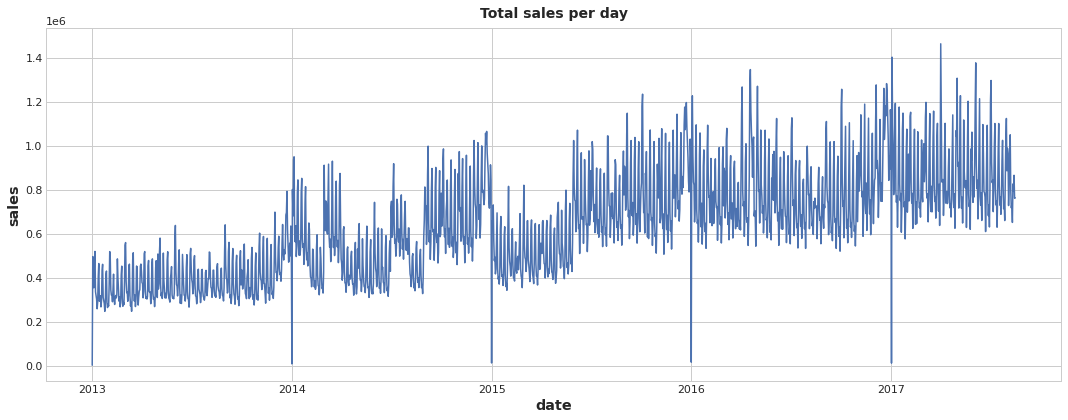

In [8]:
sales_date = train_EDA.groupby(['date'])['sales'].sum().reset_index()
sns.lineplot(x='date', y='sales', data= sales_date)
plt.title("Total sales per day")
plt.show()

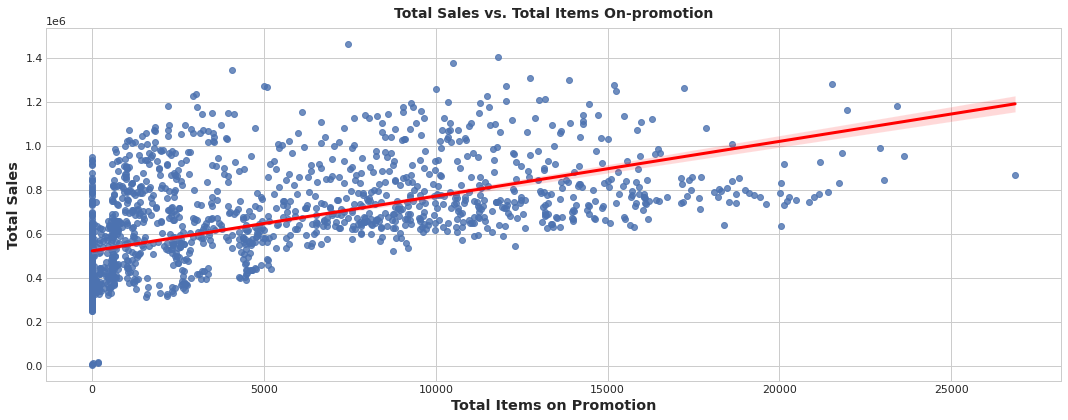

In [9]:
sales_onpromotion = train_EDA.groupby(['date'])['sales','onpromotion'].sum().reset_index()

sns.regplot(x='onpromotion',y='sales', data=sales_onpromotion, line_kws={'color':'red','linewidth':3})
plt.xlabel('Total Items on Promotion')
plt.ylabel('Total Sales')
plt.title('Total Sales vs. Total Items On-promotion')
plt.show()

**There is a positive correlation between Total Sales and Total item on-promotion --> More sales while on-promotion**

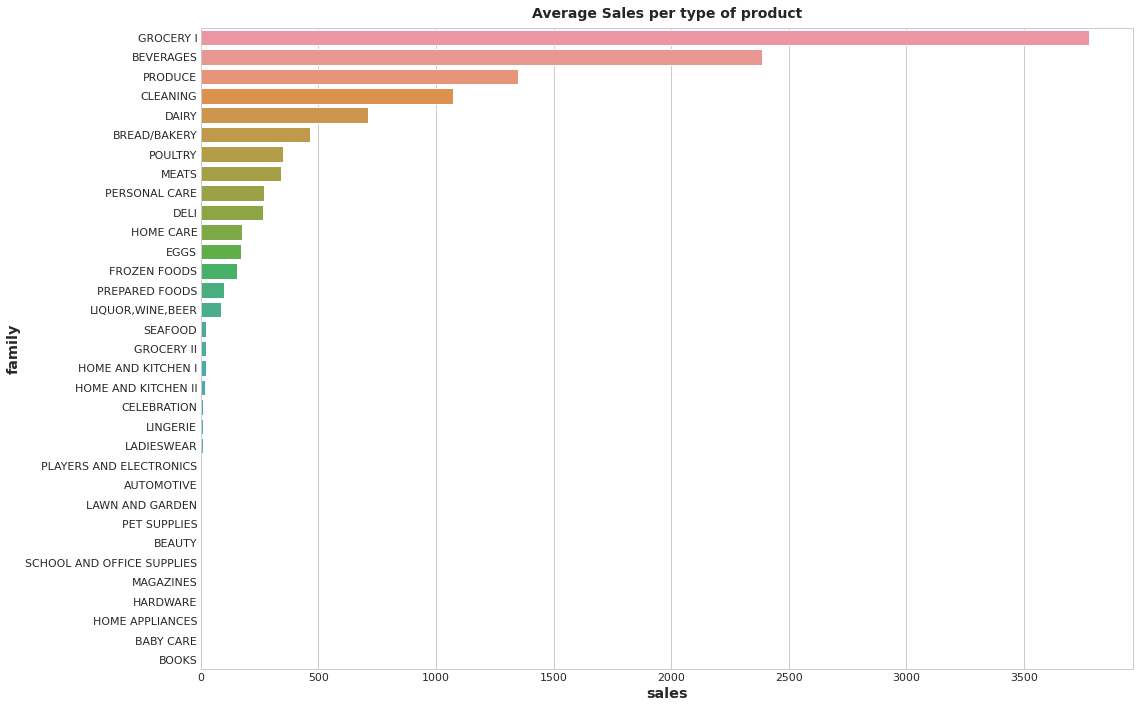

In [10]:
temp = train_EDA.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()
plt.figure(figsize=(16,10))
sns.barplot(data=temp, x=temp.sales, y=temp.index, ci=None, order=list(temp.index))
plt.title("Average Sales per type of product")
plt.show()

**Observation: The best selling products are Grocery I, Beverages, Produce, Cleaning and Dairy.**

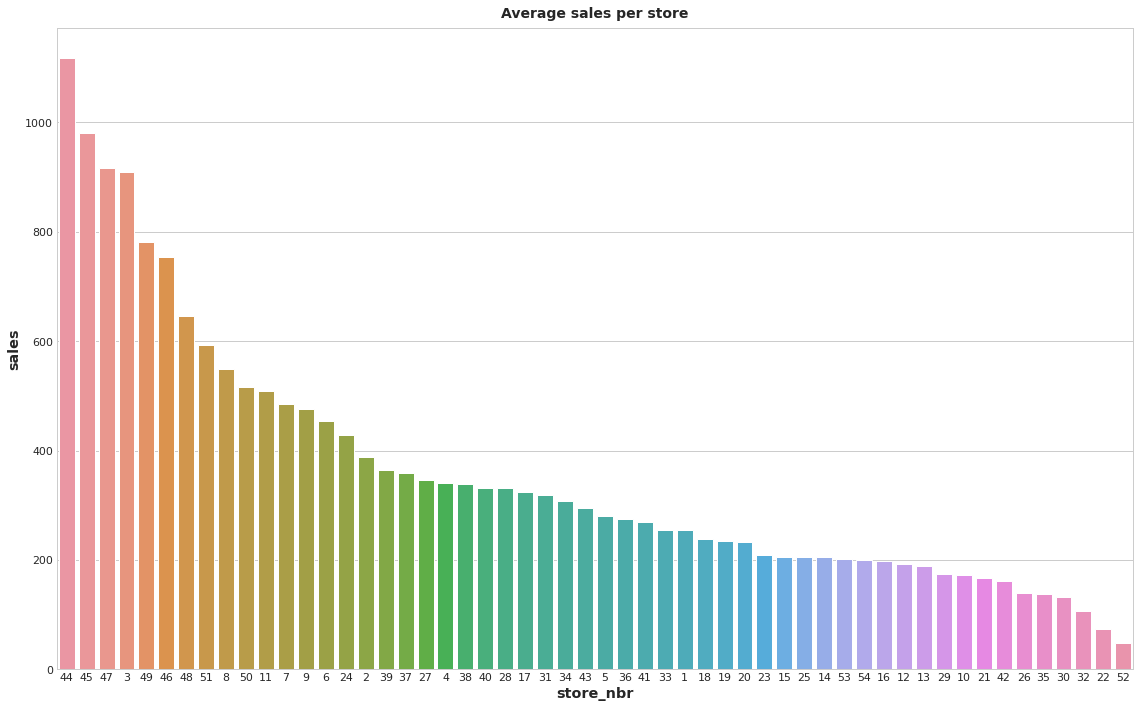

In [11]:
temp = train_EDA.groupby('store_nbr')['sales'].mean().sort_values(ascending=False).to_frame()
plt.figure(figsize=(16,10))
plt.title("Average sales per store")
sns.barplot(data=temp, x=temp.index, y=temp.sales, order=list(temp.index))
plt.show()

**Observation: Stores 44, 45, 3 and 47 sell more**

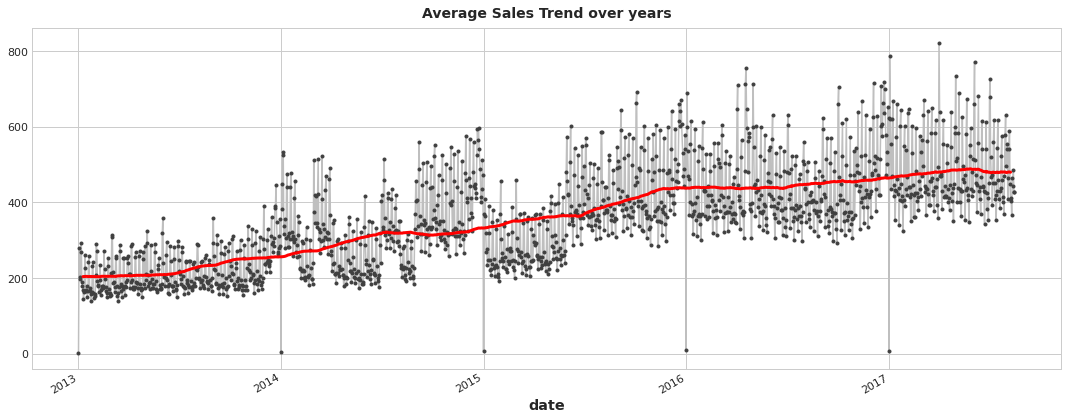

In [12]:
average_sales = train_EDA.groupby(['date'])['sales'].mean()

moving_average = average_sales.rolling(
    window=350,
    center=True,
    min_periods=183,
).mean()

ax=average_sales.plot(**plot_params)
ax=moving_average.plot(ax=ax, color='red', linewidth=3)
plt.title("Average Sales Trend over years")
plt.show()

**Observation: Trend --> increasing sales with time**

## **Seasonality**

In [13]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


****Seasonal Plot using Seasonal indicators****

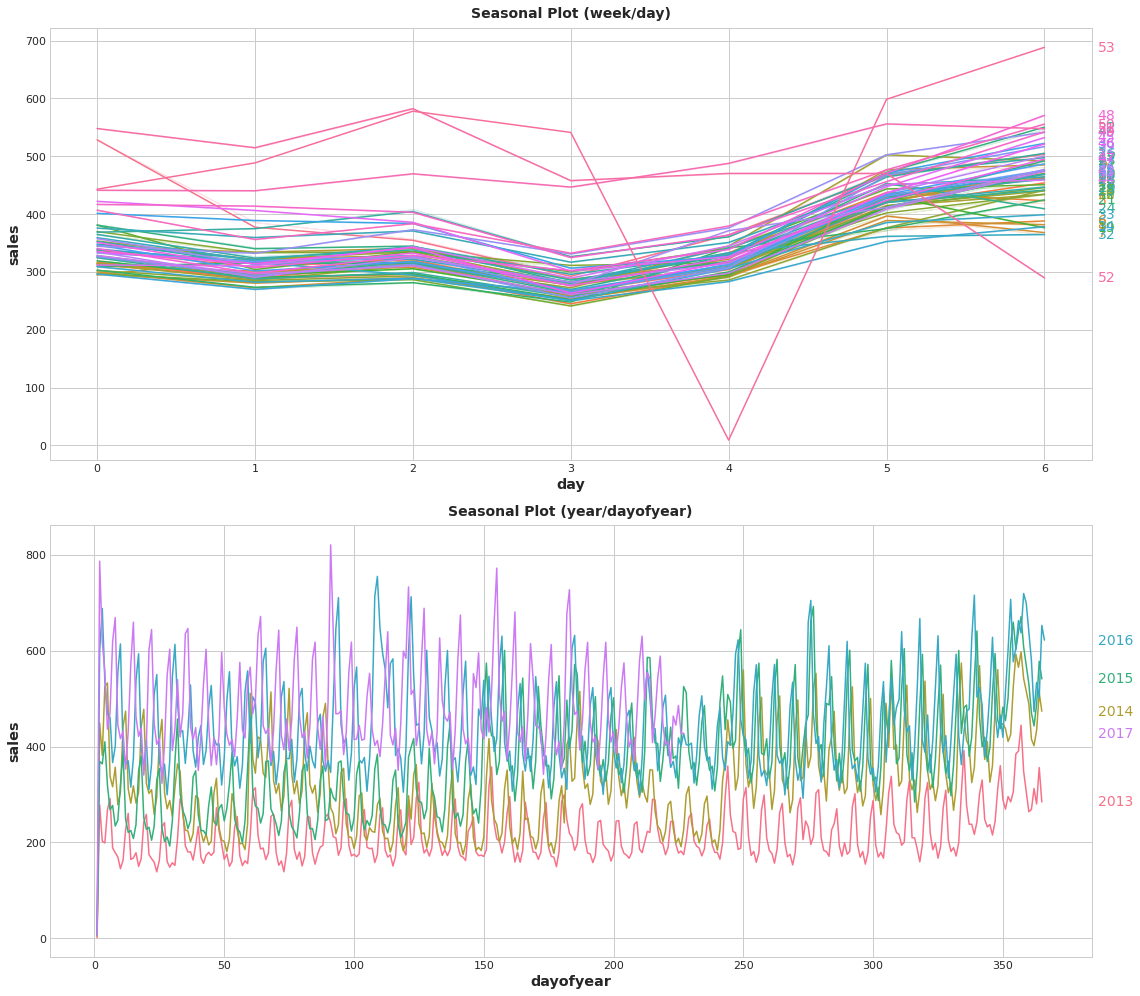

In [14]:
average_sales = train_EDA.groupby('date')['sales'].mean().to_frame() #Convert Series to DataFrame

# days within a week
average_sales["day"] = average_sales.index.dayofweek  # the x-axis (freq). Defining columns with Day of the week. Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. This method is available on both Series with datetime values (using the dt accessor) or DatetimeIndex.
average_sales["week"] = average_sales.index.week  # the seasonal period (period)

# days within a year
average_sales["dayofyear"] = average_sales.index.dayofyear
average_sales["year"] = average_sales.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 14))
seasonal_plot(average_sales, y=average_sales['sales'], period="week", freq="day", ax=ax0)
seasonal_plot(average_sales, y=average_sales['sales'], period="year", freq="dayofyear", ax=ax1)
plt.show()

**Observations:**
- **There is a clear weekly seasonality shown in the first plot: Sales are higher during the weekend**
- **The second plot is an example of seasonal indicators not working very well for seasons with many observations --> Try Fourier Features**

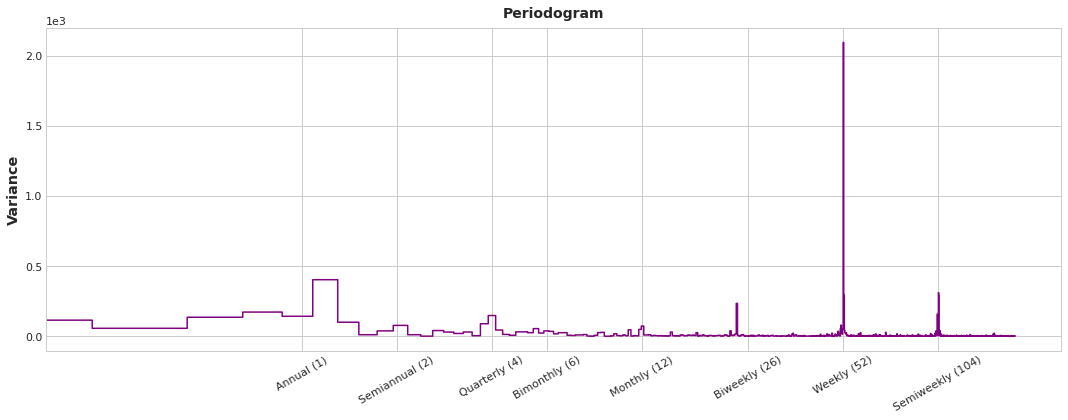

In [15]:
plot_periodogram(average_sales['sales']) #Could be also (average_sales.sales)
plt.show()

**Observations: Both seasonal plot and periodogram show a strong weekly seasonability. The periodogram suggest an anual and maybe a biweekly seasonality as well.**

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig





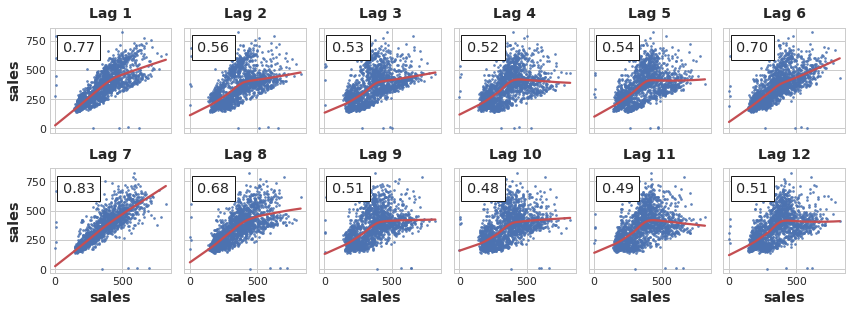

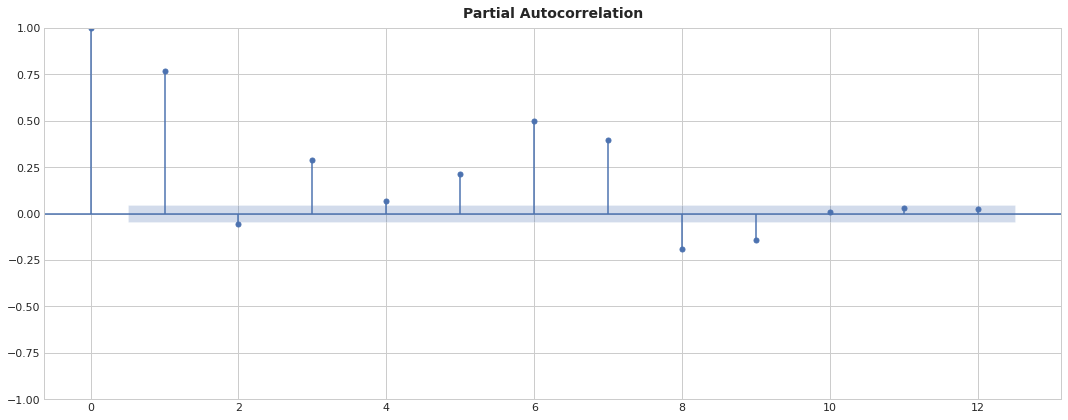

In [17]:
_ = ax.set(ylabel="average sales")

_ = plot_lags(average_sales.sales, lags=12, nrows=2)
_ = plot_pacf(average_sales.sales, lags=12)

**Observations: The lag plots indicate that the relationship of average_sales to lag=7 is linear (maybe lag 1? not sure...), while the partial autocorrelation suggest that the dependence can be captured using lags 1,3,4,5,6,7 and 8. --> Non-linear relationships can either be transformed to be linear or else learned by an appropiated algorithm.**

<a id="section_three"></a>
# **Aditional data**

<a id="subsection_one_three"></a>
## **Holiday events**

In [18]:
holiday_events = pd.read_csv(data_dir / 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
holiday_events_EDA = holiday_events.copy()
holiday_events_EDA.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [19]:
display(holiday_events_EDA.info())
info(holiday_events_EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


None

==========date ==========
Type is:  datetime64[ns]
2014-06-25    4
2017-06-25    3
2016-06-25    3
2015-06-25    3
2013-06-25    3
             ..
2014-07-13    1
2014-07-12    1
2014-07-09    1
2014-07-08    1
2017-12-26    1
Name: date, Length: 312, dtype: int64
Number of unique values:  312
Number of null values:  0
==========type ==========
Type is:  object
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64
Number of unique values:  6
Number of null values:  0
==========locale ==========
Type is:  object
National    174
Local       152
Regional     24
Name: locale, dtype: int64
Number of unique values:  3
Number of null values:  0
==========locale_name ==========
Type is:  object
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             

PAY ATTENTION TO THE DESCRIPTION OF THE DATA:
"A holiday that is transferred officially falls on that calendar day, 
but was moved to another date by the government." --> Since the hypothesis supposes sales are higher due to people having the day off, holidays that are transferred to another day won't be useful for the model. So I will drop them. The same for holidays that are announced as Work Day. 

Also, entries are 350 for the data set but there is just 312 unique values for dates --> duplicated values or just local in more than a locale_name?? --> for now I won't drop them 

In [20]:
holiday_events_EDA = holiday_events_EDA.loc[(holiday_events_EDA['transferred']==False) & (holiday_events_EDA['type']!='Work day')]

There is 3 different types of Holiday --> Check if all of them are useful for the model. 

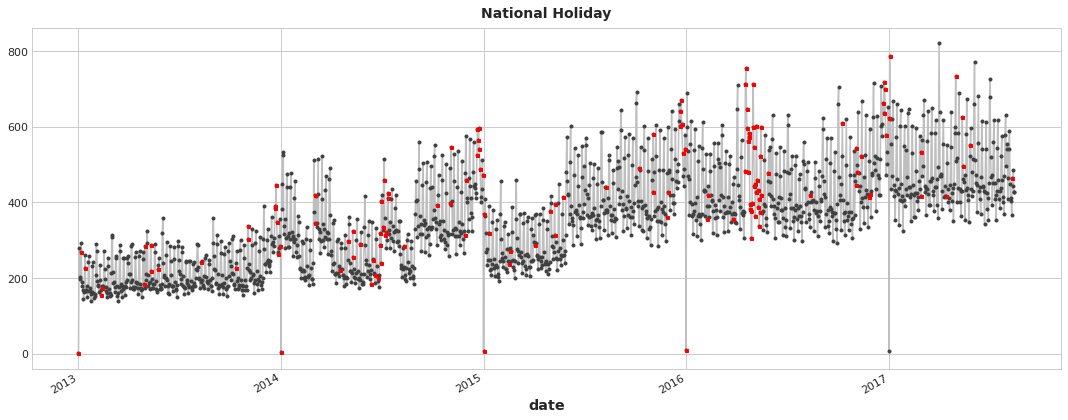

In [21]:
NHolidays = holiday_events_EDA.loc[holiday_events_EDA['locale']=='National']
NHolidays_avg_sales = average_sales.reset_index().merge(NHolidays, on='date',how='left')

x_cor = NHolidays_avg_sales.loc[NHolidays_avg_sales['type'].notna(),'date'].values #NaN values are days that came from average_sales after the merge but they don't correspond to a holiday. 
y_cor = NHolidays_avg_sales.loc[NHolidays_avg_sales['type'].notna(),'sales'].values
_= average_sales['sales'].plot(**plot_params)
_=plt.plot(x_cor, y_cor,'s', color='red', markersize=3, label='National Holiday')
_=plt.title('National Holiday')
plt.show()

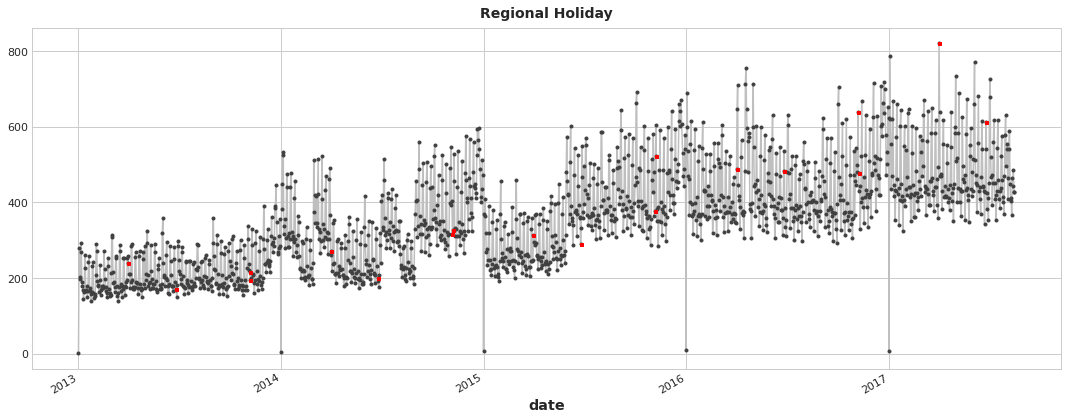

In [22]:
RHolidays = holiday_events_EDA.loc[holiday_events_EDA['locale']=='Regional']
RHolidays_avg_sales = average_sales.reset_index().merge(RHolidays, on='date',how='left')
x_cor = RHolidays_avg_sales.loc[RHolidays_avg_sales['type'].notna(),'date'].values
y_cor = RHolidays_avg_sales.loc[RHolidays_avg_sales['type'].notna(),'sales'].values
_= average_sales['sales'].plot(**plot_params)
_=plt.plot(x_cor, y_cor,'s', color='red', markersize=3, label='Regional Holiday')
_=plt.title('Regional Holiday')

plt.show()

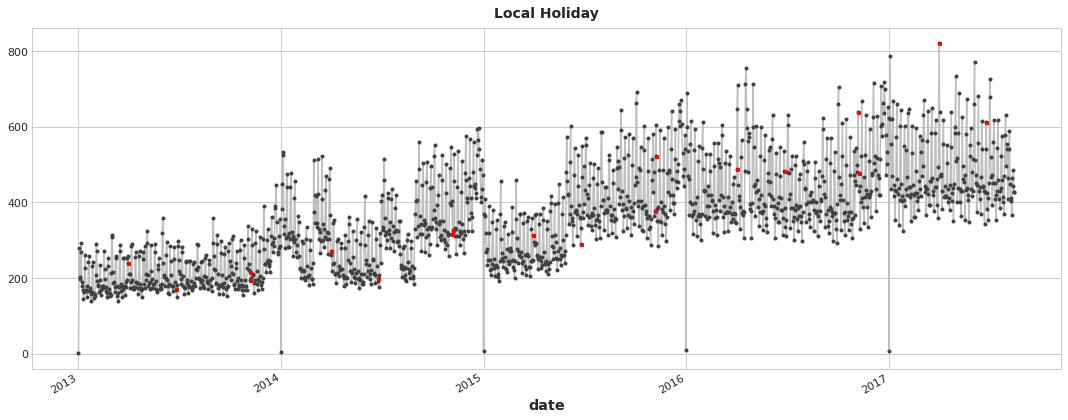

In [23]:
LHolidays = holiday_events_EDA.loc[holiday_events_EDA['locale']=='Local']
LHolidays_avg_sales = average_sales.reset_index().merge(RHolidays, on='date',how='left')
x_cor = LHolidays_avg_sales.loc[LHolidays_avg_sales['type'].notna(),'date'].values
y_cor = LHolidays_avg_sales.loc[LHolidays_avg_sales['type'].notna(),'sales'].values
_= average_sales['sales'].plot(**plot_params)
_=plt.plot(x_cor, y_cor,'s', color='red', markersize=3, label='Local Holiday')
_=plt.title('Local Holiday')

plt.show()

**Observation: Regional and Local holidays don't have much impact on the average sales, while National holidays does --> I'll keep just the National Holiday and create a new feature, which reflects national holidays, in training set. For the merge, I'll keep just 'date' and 'type'.**

tutorial adds weekends as holidays --> won't do it for now. --> is not consider in the seasonality already?? 

<a id="subsection_two_three"></a>
## **OIL PRICE**

* Hypothesis: 
    Since Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices, probably there is a dependency between sales and oil price. For the industry is cheaper to produce when the oil price is lower and for householders as well. Oil price is closely related to the petrol/gasoil price, which translates in consumer's buying power. 

In [24]:
oil_price = pd.read_csv(data_dir / 'oil.csv', parse_dates=['date'], infer_datetime_format=True)
oil_price.set_index('date', inplace=True)
oil_price_EDA = oil_price.copy()
oil_price_EDA.info()
info(oil_price_EDA)
oil_price_EDA.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB
==========dcoilwtico ==========
Type is:  float64
47.72    4
47.65    4
96.44    4
60.01    4
46.02    4
        ..
94.35    1
96.40    1
93.97    1
95.39    1
47.26    1
Name: dcoilwtico, Length: 998, dtype: int64
Number of unique values:  998
Number of null values:  43


,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


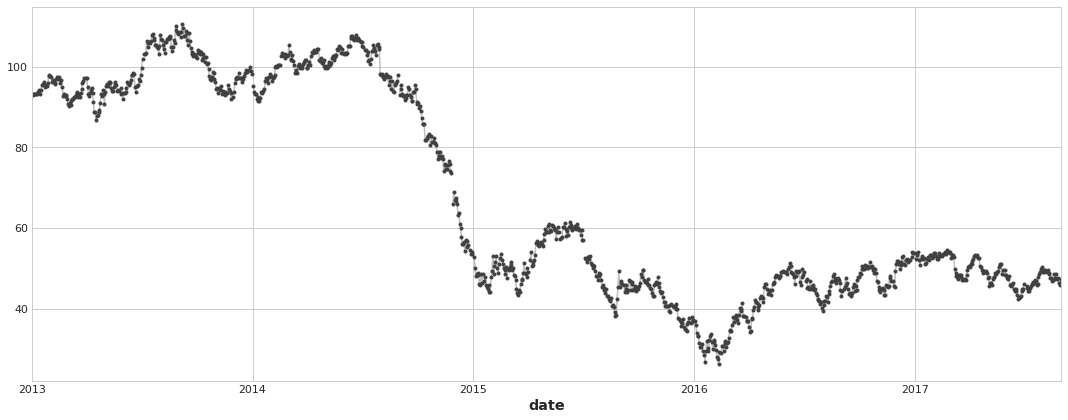

In [25]:
oil_price_EDA.plot(**plot_params)
plt.show()

In [26]:
train_EDA_temp = pd.merge(left=train_EDA, right=oil_price, on='date')
train_EDA_temp.rename({'dcoilwtico':'oil_price'}, axis=1, inplace=True)

train_EDA_temp['oil_price'] = train_EDA_temp['oil_price'].fillna(method='ffill').fillna(method='bfill') #filling missing values
train_EDA_temp.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,93.14


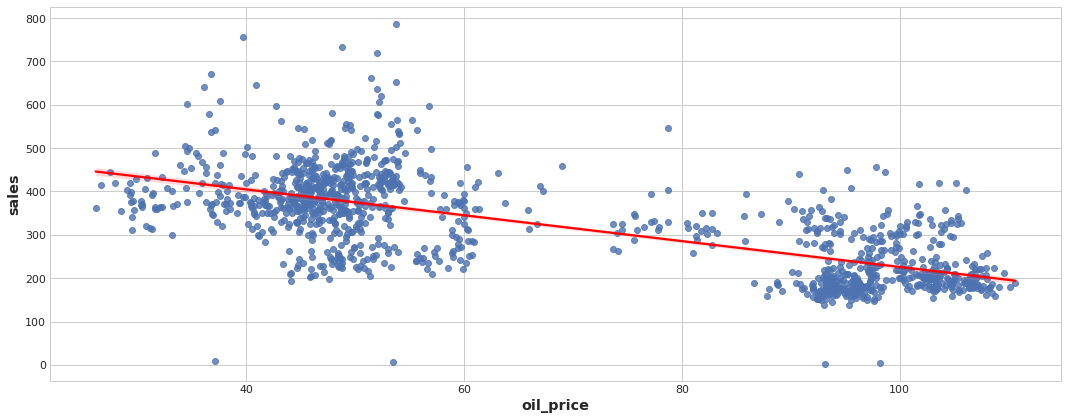

In [27]:
average_sales = train_EDA_temp.groupby(['date','oil_price'])['sales'].mean().reset_index()

sns.regplot(data=average_sales, x='oil_price', y='sales', line_kws={'color':'red'})
plt.show()

**Observations: The plot shows a clear relationship between average sales and oil price, confirming the inital hypothesis.**

<a id="subsection_three_three"></a>
## **Stores** 

- Hypothesis: stores would diferent sales depending on location, due to the socio-economic characteristics of each area. Also the type of store could affect sales (not sure what would type of store mean.. )

In [28]:
stores_info = pd.read_csv(data_dir / 'stores.csv')
stores_info_EDA = stores_info.copy()
stores_info_EDA.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [29]:
stores_info_EDA.info()
info(stores_info_EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
==========store_nbr ==========
Type is:  int64
1     1
41    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
42    1
2     1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
29    1
28    1
27    1
26    1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
54    1
Name: store_nbr, dtype: int64
Number of unique values:  54
Number of null values:  0
==========c

In [30]:
average_sales = train_EDA.groupby(['store_nbr'])['sales'].mean().reset_index()
stores_info_EDA = stores_info_EDA.merge(average_sales, on='store_nbr', how='left')

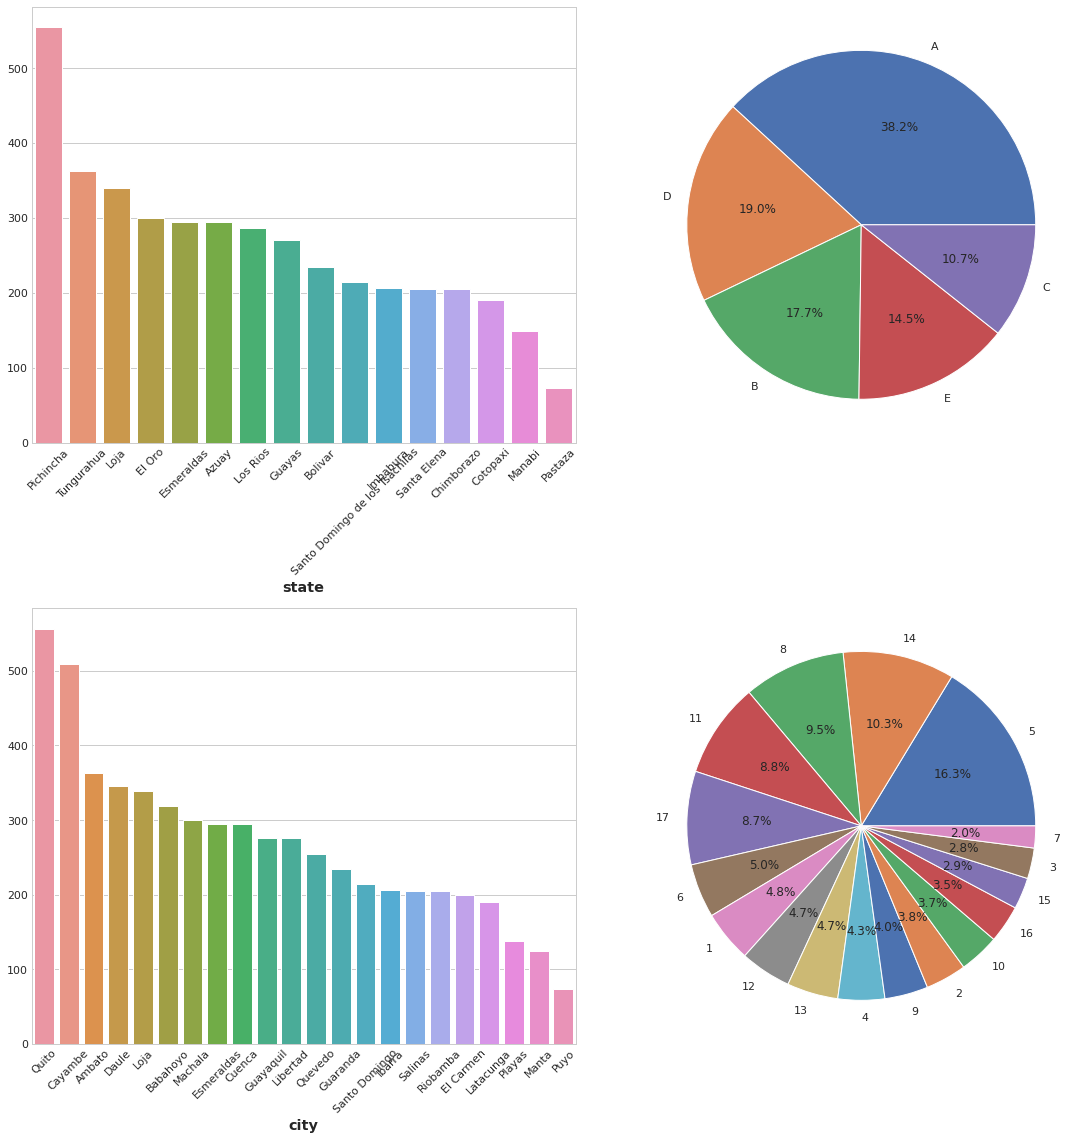

In [31]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
by_state = stores_info_EDA.groupby('state')['sales'].mean().sort_values(ascending=False)
sns.barplot(x=by_state.index, y=by_state.values)
plt.xticks(rotation=45)

plt.subplot(2,2,2)
by_type = stores_info_EDA.groupby('type')['sales'].mean().sort_values(ascending=False)
plt.pie(by_type, labels=by_type.index, autopct='%1.1f%%')

plt.subplot(2,2,3)
by_city = stores_info_EDA.groupby('city')['sales'].mean().sort_values(ascending=False)
sns.barplot(x=by_city.index, y=by_city.values)
plt.xticks(rotation=45)


plt.subplot(2,2,4)
by_cluster = stores_info_EDA.groupby('cluster')['sales'].mean().sort_values(ascending=False)
plt.pie(by_cluster, labels=by_cluster.index, autopct='%1.1f%%')

plt.show()

In [32]:
## Converting dtypes for stores variables to category for simplification.
stores_info['type'] = pd.Categorical(stores_info['type'], categories=by_type.index[::-1], ordered=True)
stores_info['cluster'] = pd.Categorical(stores_info['cluster'], categories=by_cluster.index[::-1], ordered=True)
stores_info['city'] = pd.Categorical(stores_info['city'], categories=by_city.index[::-1], ordered=True)
stores_info['state'] = pd.Categorical(stores_info['state'], categories=by_state.index[::-1], ordered=True)


<a id="subsection_four_three"></a>
## **Transactions**

In [33]:
transactions = pd.read_csv(data_dir / 'transactions.csv', parse_dates=['date'], infer_datetime_format=True)
transactions_EDA = transactions.copy()
transactions_EDA.info()
info(transactions_EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
==========date ==========
Type is:  datetime64[ns]
2017-08-15    54
2017-06-02    54
2017-05-21    54
2017-05-22    54
2017-05-23    54
              ..
2016-01-04    14
2014-01-01     2
2017-01-01     1
2015-01-01     1
2013-01-01     1
Name: date, Length: 1682, dtype: int64
Number of unique values:  1682
Number of null values:  0
==========store_nbr ==========
Type is:  int64
39    1678
38    1678
26    1678
31    1678
33    1678
34    1678
37    1678
27    1677
28    1677
32    1677
23    1677
40    1677
41    1677
44    1677
45    1677
46    1677
47    1677
48    1677
50    

The correlation between total sales & transactions is:  0.8374 



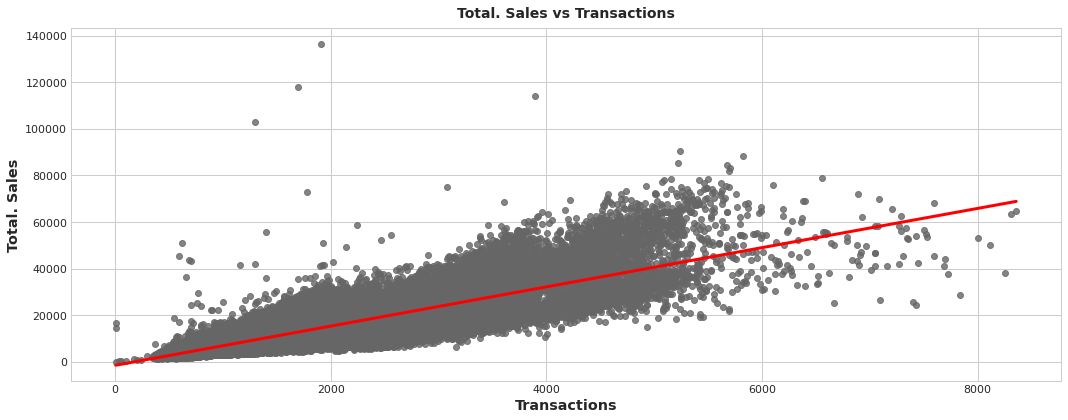

In [34]:
#Total Sales vs Transactions 
average_sales = train_EDA.groupby(['date','store_nbr'])['sales'].sum().reset_index() 

transactions_EDA = transactions_EDA.merge(average_sales, how = "left")

print('The correlation between total sales & transactions is: ',
      np.round(transactions_EDA[['sales','transactions']].corr().iloc[0,1],4),'\n')

# Plotting
sns.regplot(data=transactions_EDA,x='transactions',y='sales',ci=None,
            scatter_kws={'color':'0.4'},line_kws={'color':'red','linewidth':3})
plt.xlabel('Transactions')
plt.ylabel('Total. Sales')
plt.title('Total. Sales vs Transactions')
plt.show()

NOT SURE IF TRANSACTIONS WOULD BE A GOOD PREDICTION FEATURE.. MAYBE IS A CASE OF DATA LEAKAGE?? (TARGET LEAKAGE)

<a id="section_four"></a>
# **MODELING** 

In [35]:
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

In [36]:
store_sales = train_data.drop('id', axis=1).set_index(['store_nbr','family', 'date'])
store_sales.head()


sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
          BABY CARE  2013-01-01    0.0            0
          BEAUTY     2013-01-01    0.0            0
          BEVERAGES  2013-01-01    0.0            0
          BOOKS      2013-01-01    0.0            0

In [37]:
family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr', 'family']).loc['2017']
family_sales.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0      166.819   
2017-01-03        4.0       0.0    4.0    3081.0   2.0      519.348   
2017-01-04        1.0       0.0    4.0    3039.0   2.0      543.251   
2017-01-05        2.0       0.0    3.0    2617.0   0.0      533.480   

                                                  ...                     \
store_nbr                                         ...         9            
family     CELEBRATION CLEANING   DAIRY     DELI  ... MAGAZINES    MEATS   
date                                              ...                      
2017-01-01         0.0      0.0     0.0    0.000  ...       0.0    0.000   
2017-01-02         0.0    332.0   376.0   44.980  ...       5.0  659.570   
2017-01-03        15.0    952.0  1045.0  209.300  ...       2.0  547.364   
2017-01-04        17.0   1055.0  1029.0  135.944  ...       3.0  395.288   
2017-01-05        40.0    918.0   853.0  137.006  ...       2.0  470.768   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2017-01-01           0.0          0.0                     0.0    0.000   
2017-01-02        1243.0         11.0                    41.0  843.596   
2017-01-03         876.0          6.0                    15.0  714.660   
2017-01-04         677.0          6.0                    13.0  536.830   
2017-01-05         604.0          7.0                    10.0  414.100   

                                                                        
store_nbr                                                               
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                    
2017-01-01       0.000000     0.000                        0.0     0.0  
2017-01-02     115.188995  3136.896                        1.0    23.0  
2017-01-03     133.039000  3229.558                        1.0    14.0  
2017-01-04      75.201004  1491.417                        7.0     0.0  
2017-01-05     113.699000  1566.821                        1.0    17.0  

[5 rows x 1782 columns]

In [38]:
family_sales.index = family_sales.index.to_period('D')


### Time Series

In [39]:
y = family_sales.loc(axis=1)['sales']
fourier = CalendarFourier(freq='M', order=4)

# Deterministic process to consider sales TREND of increasing in time. 
dp = DeterministicProcess(index=y.index, 
                          order=1, #Trend
                          seasonal=True, #weekly seasonality indicators
                          additional_terms=[fourier], #monthly seasonality fourier
                          drop=True)

X_train_1 = dp.in_sample()

### Holiday events

In [40]:
holiday_events = pd.read_csv(data_dir / 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
holiday_events = holiday_events.loc[(holiday_events['transferred']==False) & (holiday_events['type']!='Work day')]
holiday_events = holiday_events.loc[holiday_events['locale']=='National'][['date','type']]


In [41]:
X_train_1.index = X_train_1.index.to_timestamp()
X_train_1 = X_train_1.reset_index().merge(holiday_events, on='date', how='left')
X_train_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_train_1['is_holiday'] = X_train_1.is_holiday.map({'Holiday':1,'Additional':1,'Event':1,
                                                  'Bridge':1,'Transfer':1}).fillna(0).astype('int8')

X_train_1['start_of_year'] = (X_train_1.date.dt.dayofyear==1)
X_train_1.loc[X_train_1['start_of_year']==True, 'is_holiday']=0
X_train_1['start_of_year'] = X_train_1['start_of_year'].astype('int8')

X_train_1 = X_train_1.set_index('date')
X_train_1.index = X_train_1.index.to_period('D')

In [42]:
def fit(model_1, model_2, X_train_1, X_train_2, y):
    
    """ 
    Inputs: 
     - model_1: first model of the hybrid modelling
     - model_2: second model of the hybrid modelling
     - X_train_1: dataset for model_1
     - X_train_2: dataset for model_2
     - y: target of training data of model_1
    
    Output:
     - Fitting of the Hybrid model
     
    """
    
    model_1.fit(X_train_1,y)
    
    #Make predictions with model_1
    y_fit = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns)
    
    y_resid = y - y_fit
    y_resid = y_resid.unstack().reset_index(['store_nbr', 'family', 'date'])
    y_resid['date'] = y_resid['date'].dt.to_timestamp()
    y_resid = y_resid.set_index(['store_nbr','family','date'])
    y_resid.rename({0:'residuals'},axis=1,inplace=True)
    
    # re-order the index of y_resid as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_resid = y_resid.reindex(new_index.index)
    
    y_resid.reset_index(['store_nbr','family'], drop=True, inplace=True) # drop unneccessary varibales
    
    model_2.fit(X_train_2, y_resid)
    
    
def predict(model_1, model_2, X_train_1, X_train_2):
        
    global y 
    y_pred = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns) # prediction of 1st model

    y_pred = y_pred.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_pred['date'] = y_pred['date'].dt.to_timestamp()
    y_pred = y_pred.set_index(['store_nbr','family','date'])
    y_pred.rename({0:'sales'},axis=1,inplace=True)
    
    # re-order the index of y_pred as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_pred = y_pred.reindex(new_index.index)
    
    values = y_pred['sales'].values
    sales = model_2.predict(X_train_2) + values
    y_pred['sales'] = sales.clip(0.0)  ## clipping values < 0 to 0.0
    
    return y_pred 
    

In [43]:
model_1 = LinearRegression() 

model_2 = CatBoostRegressor(silent= True) ## by default hyperparameter

# X_train_2: Features for CatBoost
X_train_2 = train_data.drop(['id','sales'],axis=1).set_index('date').loc['2017'] #all original features of train data

# Label encoding for 'family'
le = LabelEncoder()
X_train_2['family'] = le.fit_transform(X_train_2['family'])

X_train_2['start_of_year']= (X_train_2.index.dayofyear ==1).astype('int8')


fit(model_1, model_2, X_train_1, X_train_2, y)

y_pred= predict(model_1, model_2, X_train_1, X_train_2)

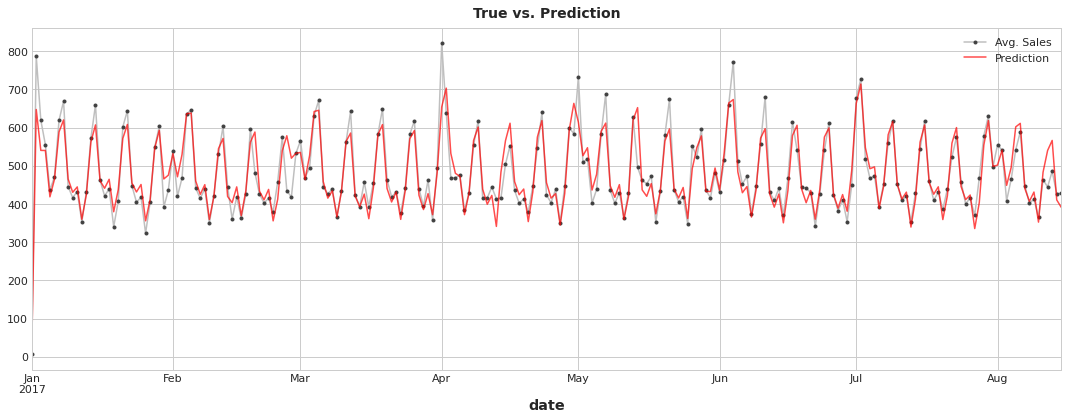

In [44]:
ax=y.mean(axis=1).plot(**plot_params, label='Avg. Sales', title='True vs. Prediction')
ax=y_pred.groupby('date')['sales'].mean().plot(color='red', alpha=0.7, label='Prediction', legend=True)
ax=plt.legend()
plt.show()

In [45]:
X_test_1 = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
X_test_1.index = X_test_1.index.rename('date').to_timestamp()

## Merging and Mapping:
X_test_1=X_test_1.reset_index().merge(holiday_events,on='date',how='left').set_index('date')
X_test_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_test_1['is_holiday']=X_test_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_test_1['is_holiday']=X_test_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_test_1['day_of_week'] = X_test_1.index.day_of_week.astype('int8')
X_test_1.loc[(X_test_1['day_of_week']==5) | (X_test_1['day_of_week']==6), 'is_holiday'] = 1
X_test_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays as mentioned before Favorita is closed these days.
X_test_1['start_of_year']= (X_test_1.index.dayofyear ==1)
X_test_1.loc[X_test_1['start_of_year']==True, 'is_holiday']=0
X_test_1['start_of_year'] = X_test_1['start_of_year'].astype('int8')
X_test_1.index = X_test_1.index.to_period('D')

X_test_2=test_data.set_index('date')
X_test_2 = X_test_2.drop('id', axis = 1)
X_test_2['start_of_year']= (X_test_2.index.dayofyear ==1).astype('int8')
X_test_2['family'] = le.transform(test_data['family'])

In [46]:
target = predict(model_1, model_2, X_test_1, X_test_2)

In [47]:
submission = pd.read_csv(data_dir / 'sample_submission.csv')
submission['sales'] = target.reset_index()['sales']
submission.to_csv('submission.csv', index=False)

In [48]:
submission.head()

,id,sales
0,3000888,5.692227
1,3000889,1.399322
2,3000890,3.136791
3,3000891,2341.530779
4,3000892,1.899176
